**this data set is trained on 1000 OBJ which are not just related to flowers or cars but a lot**

first we make prediction staright out of it then we use it to give our outputs rather than pre-determined outputs

In [1]:
import numpy as np
import cv2
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)
from keras.applications.mobilenet_v2 import MobileNetV2


In [3]:
base_model=MobileNetV2(input_shape=(224,224,3),weights='imagenet')

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it
import pathlib
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


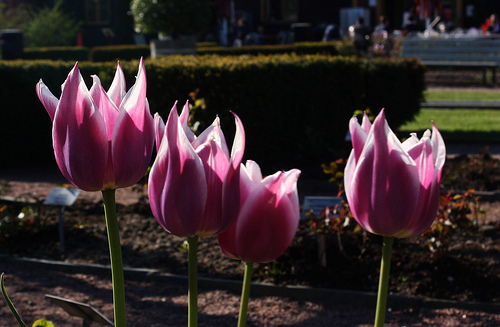

In [5]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

In [6]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])
X = np.array(X)
y = np.array(y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [8]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [9]:
predicted = base_model.predict(X_train,batch_size=32)


86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step


In [10]:
np.argmax(predicted[0:5])
for i in predicted[:5]:
  print(np.argmax(i))#the prediction numbers are for defined 1000 obj

721
549
794
794
794


now we use the base model to train out own nn

In [26]:
feature_extractor = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet',include_top=False)
#

include_top=True/False-> True:indicates the i/p and o/p Dense layer of pre trained model

False:indicates dont use Dense layer of PreTrained model but just ConV Layer->{more acc}

In [27]:
feature_extractor.trainable=False #to stop model from training from new data

In [28]:
model=Sequential([
    feature_extractor,
    layers.Flatten(),
    layers.Dense(224,activation='relu'),
    layers.Dense(5,activation='softmax')
])

In [29]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 224)                 │      14,049,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,308,613 (62.21 MB)

 Trainable params: 14,050,629 (53.60 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6266 - loss: 5.9918
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9450 - loss: 0.1668
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9941 - loss: 0.0200
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9988 - loss: 0.0074
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 1.0000 - loss: 0.0024


In [32]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8379 - loss: 0.6142


[0.6219742298126221, 0.8474945425987244]